In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import emcee
import triangle
from math import sqrt, exp

In [3]:
wlHa=6562.8
wlNIIa =6548.1
wlNIIb=6583.5

par_fixha = ['continuum', 'redshift', 'flux Ha', 'flux NII']
par_slope = ['continuum', 'slope']
par_flat = ['continuum']

nwalkers = 100
nburn = 1000
nsamp = 1000

In [4]:
def gaussian(x, ampl, centre, sigma):
    # with unit area
    return (ampl/(sigma*sqrt(2*pi))) * np.exp(-(x-centre)**2/(2.0*sigma**2))

In [5]:
def softbox(x, low, high, edgelevel=0.9, cutoffwidth=None, cutofflevel=0.01):
    """A soft-edged box function
    
    This produces a box over the range low to high, with soft edges.
    It has value one in the centre of the range, and decreases to
    edgelevel at the edges (x=low and x=high), and further decreases
    to cutofflevel after a further cutoffwidth, i.e. at x = low - cutoffwidth
    and vice versa.
    
    """
    centre = 0.5*(high + low)
    halfwidth = 0.5*(high - low)
    index = np.log(np.log(cutofflevel)/np.log(edgelevel)) / np.log((halfwidth + cutoffwidth)/halfwidth)
    index = int(ceil(index))
    if index%2 != 0:
        index += 1
    sigma = -(halfwidth)**index / np.log(edgelevel)
    return np.exp(-(x-centre)**index / sigma)

In [6]:
def fixha_model(x, p):
    model = p[0] + gaussian(x, p[2], (1+p[1])*wlHa, 7)
    model += gaussian(x, p[3]/3.06, (1+p[1])*wlNIIa, 7) + gaussian(x, p[3], (1+p[1])*wlNIIb, 7)
    return model

In [7]:
def slope_model(x, p, x0):
    model = p[0] + p[1] * (x - x0)
    return model

In [8]:
def flat_model(x, p):
    model = p[0] + np.zeros_like(x)
    return model

In [9]:
def lnprob_fixha(p, y, x, icov):
    model = fixha_model(x, p)
    chisq = ((model - y)**2 * icov).sum()
    return -chisq/2.0

In [10]:
def lnprior_hard_fixha(p, zmin, zmax):
    # Here we set the hard priors:
    if (p[3] < 0) or (p[1] > zmax) or (p[1] < zmin) or ((p[3]/p[2]) > 3) or (p[3] > (3*p[2] + 3*p[0])):
        return -np.inf
    else:
        return 0.0

In [11]:
def lnprior_soft_fixha(p, xmin, xmax):
    continuum, redshift, fluxHa, fluxNII = p
    lnprior = 0.0
    
    # strongly penalise negative NII flux
    # by prob of exp(-1) for each 10**-17 of negative flux
    lnprior += np.where(fluxHa < 0, fluxHa/1e17, 0)
    
    # Set edges of redshift box (prior > 0.9) such that
    # peak of Halpha is in the wavelength range
    zmin = xmin/wlHa - 1
    zmax = xmax/wlHa - 1
    # Set cutoffwidth such that prior ~< 0.01 by point at which
    # Halpha is out of wavelength range by 3 sigma
    cutoffwidth = 21/wlHa
    lnprior += np.log(softbox(redshift, zmin, zmax,
                              cutoffwidth=cutoffwidth))
    
    # Limit ratio fluxNII < (3*fluxHa + 3*continuum)
    # i.e. allow for up to an EW of 3A absorption
    # Penalise for exceeding this limit
    # by prob of exp(-1) for each 10% above the limit
    NIIHa_check = 1 - fluxNII / (3*fluxHa + 3*continuum)
    lnprior += np.where(NIIHa_check < 0, NIIHa_check/0.1, 0)
    
    return lnprior

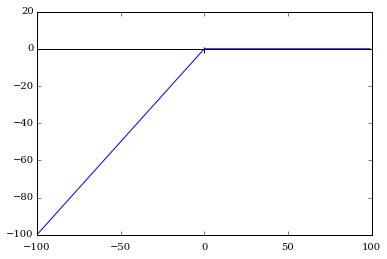

In [12]:
def lnprior_soft_fixha_fluxHa(fluxHa):
    lnp = np.where(fluxHa < 0, fluxHa, 0)
    return lnp

fluxHa = np.arange(-100, 100)
plt.plot(fluxHa, lnprior_soft_fixha_fluxHa(fluxHa))
plt.vlines([0], -2, 1)
plt.hlines([0], -100, 100)

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


(-5, 0.1)

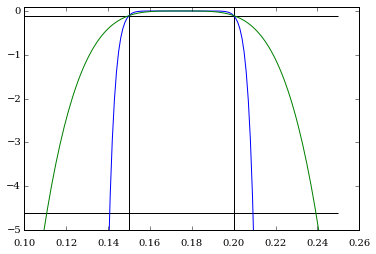

In [13]:
def lnprior_soft_fixha_z(z, zmin, zmax, cutoffwidth):
    p = softbox(z, zmin, zmax, cutoffwidth=cutoffwidth)
    return np.log(p)

z = np.arange(0.10, 0.25, 0.001)
plt.plot(z, lnprior_soft_fixha_z(z, 0.15, 0.20, 0.01))
plt.plot(z, lnprior_soft_fixha_z(z, 0.15, 0.20, 0.04))
plt.hlines(np.log([0.9, 0.01]), 0.1, 0.25)
plt.vlines([0.15, 0.20], -5, 0.1)
plt.ylim(-5, 0.1)

(-10, 0.1)

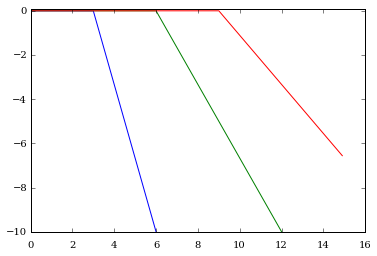

In [14]:
def lnprior_soft_fixha_NIIHa(continuum, fluxHa, fluxNII):
    NIIHa_check = 1 - fluxNII / (3*fluxHa + 3*continuum)
    return np.where(NIIHa_check < 0, NIIHa_check/0.1, 0)

NII = np.arange(0.0, 15.0, 0.1)
plt.plot(NII, lnprior_soft_fixha_NIIHa(0, 1.0, NII))
plt.plot(NII, lnprior_soft_fixha_NIIHa(0, 2.0, NII))
plt.plot(NII, lnprior_soft_fixha_NIIHa(1.0, 2.0, NII))
plt.ylim(-10, 0.1)

In [15]:
def lnprob_slope(p, y, x, icov, x0):
    model = slope_model(x, p, x0)
    chisq = ((model - y)**2 * icov).sum()
    return -chisq/2.0

In [16]:
def lnprob_flat(p, y, x, icov):
    model = flat_model(x, p)
    chisq = ((model - y)**2 * icov).sum()
    return -chisq/2.0

In [17]:
def get_data(glx):
    filename='gal_'+str(glx)+'_aper_5.txt'
    f = np.loadtxt(filename, dtype='f')
    xmeans, ymeans, error_flux_phot, error_flux_zeropointfit, error_flux = f[:,:5].T

    ## Getting rid of the nan values...
    ok = np.logical_not(np.isnan(ymeans) | np.isnan(error_flux))
    
    error_flux[error_flux == 0] = 1.0  # ARBITRARY?!?
        
    xmeans = xmeans[ok]
    ymeans = ymeans[ok]
    error_flux = error_flux[ok]
    xmin = np.min(xmeans)
    xmax = np.max(xmeans)
    ymin = np.min(ymeans)
    ymax = np.max(ymeans)
    icov = 1/error_flux**2
    zmax = (xmax+20)/wlHa - 1
    zmin = (xmin-20)/wlHa - 1
    return xmeans, ymeans, error_flux, icov, xmin, xmax, ymin, ymax, zmin, zmax

In [18]:
def flatten_without_burn(sampler, nburn):
    c = sampler.chain
    if c.ndim == 4:
        c = c[0]
    c = c[:, nburn:]
    return c.reshape((np.product(c.shape[:-1]), c.shape[-1]))

def weight_without_burn(sampler, nburn):
    c = sampler.lnprobability
    if c.ndim == 3:
        c = c[0]
    c = c[:, nburn:]
    w = np.exp(c.reshape(np.product(c.shape)))
    return w / w.sum()


In [19]:
glx = 33185
#glx = 35120
xmeans, ymeans, error_flux, icov, xmin, xmax, ymin, ymax, zmin, zmax = get_data(glx)

#ymeans = np.random.permutation(ymeans)  # scrambled
#ymeans = np.random.normal(ymeans.mean(), ymeans.std(), len(ymeans))  # noise

In [20]:
def init_p0_fixha():
    # very broad uniform initial distributions
    c0_init = np.random.uniform(ymin, ymax, nwalkers)
    z_init = np.random.uniform(zmin, zmax, nwalkers)
    fha_init = (np.random.uniform(ymin, ymax, nwalkers) - ymin) * sqrt(2*pi) * 7
    fnii_init = (np.random.uniform(ymin, ymax, nwalkers) - ymin) * sqrt(2*pi) * 7
    return np.transpose([c0_init, z_init, fha_init, fnii_init])

In [21]:
def init_p0_slope():
    # very broad uniform initial distributions
    c0_init = np.random.uniform(ymin, ymax, nwalkers)
    maxslope = (ymax-ymin)/(xmax-xmin)
    c1_init = np.random.uniform(-maxslope, maxslope, nwalkers)
    return np.transpose([c0_init, c1_init])

In [22]:
def init_p0_flat():
    # very broad uniform initial distributions
    c0_init = np.random.uniform(ymin, ymax, nwalkers)
    return np.transpose([c0_init])

In [23]:
p0 = init_p0_fixha()

ntemps = 20
def logl(x):
    return lnprob_fixha(x, ymeans, xmeans, icov)

# Use a flat prior
def logp(x):
    return lnprior_soft_fixha(x, xmin, xmax)

sampler_fixha_pt = emcee.PTSampler(ntemps, nwalkers, p0.shape[-1], logl, logp, threads=4)
r_fixha_pt = sampler_fixha_pt.run_mcmc(p0*np.ones((ntemps, nwalkers, p0.shape[-1])), nburn+nsamp)

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


In [24]:
p0 = init_p0_slope()
x0 = xmeans.mean()

ntemps = 10
def logl(x):
    return lnprob_slope(x, ymeans, xmeans, icov, x0)

# Use a flat prior in level and sin(angle)
def logp(x):
    return -1.5 * np.log(1 + x[1] ** 2)

sampler_slope_pt = emcee.PTSampler(ntemps, nwalkers, p0.shape[-1], logl, logp, threads=4)
r_slope_pt = sampler_slope_pt.run_mcmc(p0*np.ones((ntemps, nwalkers, p0.shape[-1])), nburn+nsamp)

In [25]:
p0 = init_p0_flat()

ntemps = 10
def logl(x):
    return lnprob_flat(x, ymeans, xmeans, icov)

# Use a flat prior
def logp(x):
    return 0.0

sampler_flat_pt = emcee.PTSampler(ntemps, nwalkers, p0.shape[-1], logl, logp, threads=4)
r_flat_pt = sampler_flat_pt.run_mcmc(p0*np.ones((ntemps, nwalkers, p0.shape[-1])), nburn+nsamp)

In [26]:
def plot_chain(sampler, par):
    plt.figure(figsize=[20,10])
    for i, p in enumerate(par):
        plt.subplot(2,2,i+1)
        for t in [0]: #range(ntemps):
            for w in range(nwalkers):
                plt.plot(numpy.arange(len(sampler.chain[t,0,:,0])), sampler.chain[t,w,:,i], 'r-', alpha=0.1)
        plt.xlabel(p)
        aymin, aymax = plt.ylim()
        plt.vlines(nburn, aymin, aymax, linestyle=':')
        plt.ylim(aymin, aymax)

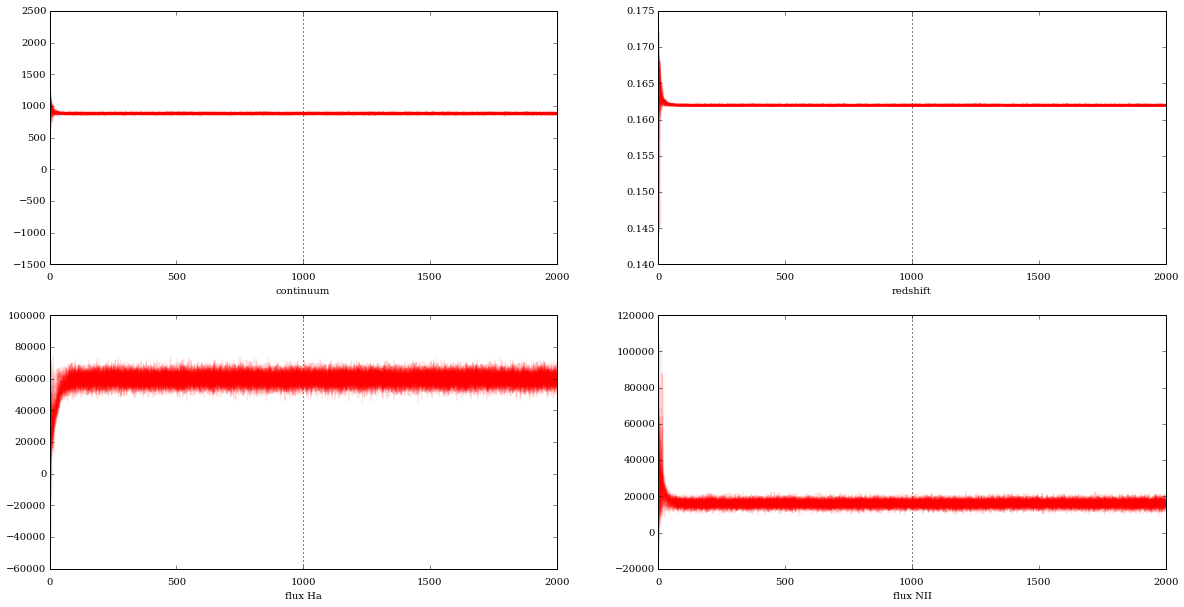

In [27]:
plot_chain(sampler_fixha_pt, par_fixha)

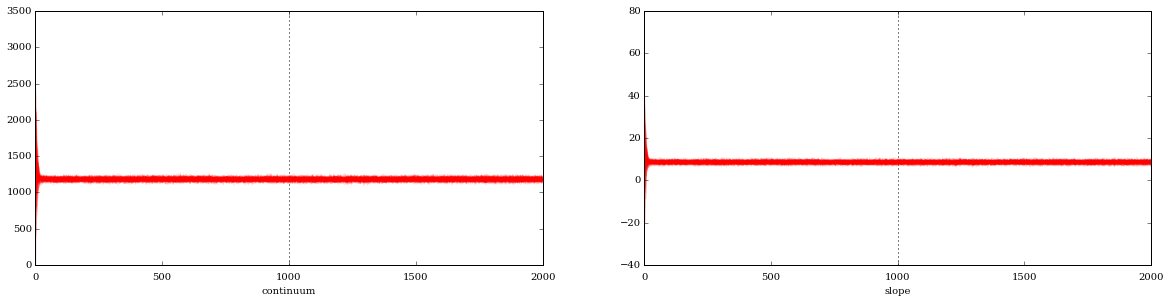

In [28]:
plot_chain(sampler_slope_pt, par_slope)

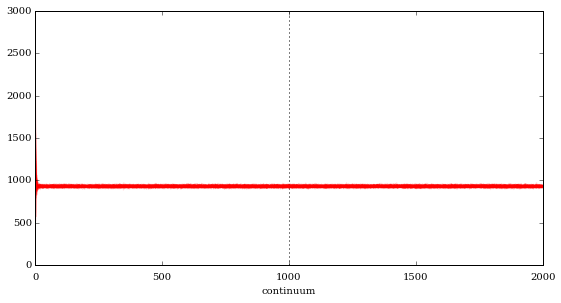

In [29]:
plot_chain(sampler_flat_pt, par_flat)

In [30]:
def plot_hist(sampler, par):
    plt.figure(figsize=[20,10])
    for i, p in enumerate(par):
        plt.subplot(2,2,i+1)
        plt.hist(flatten_without_burn(sampler, nburn)[:,i], bins=100, histtype='stepfilled', alpha=0.75)
        plt.xlabel(p)
    plt.legend()

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


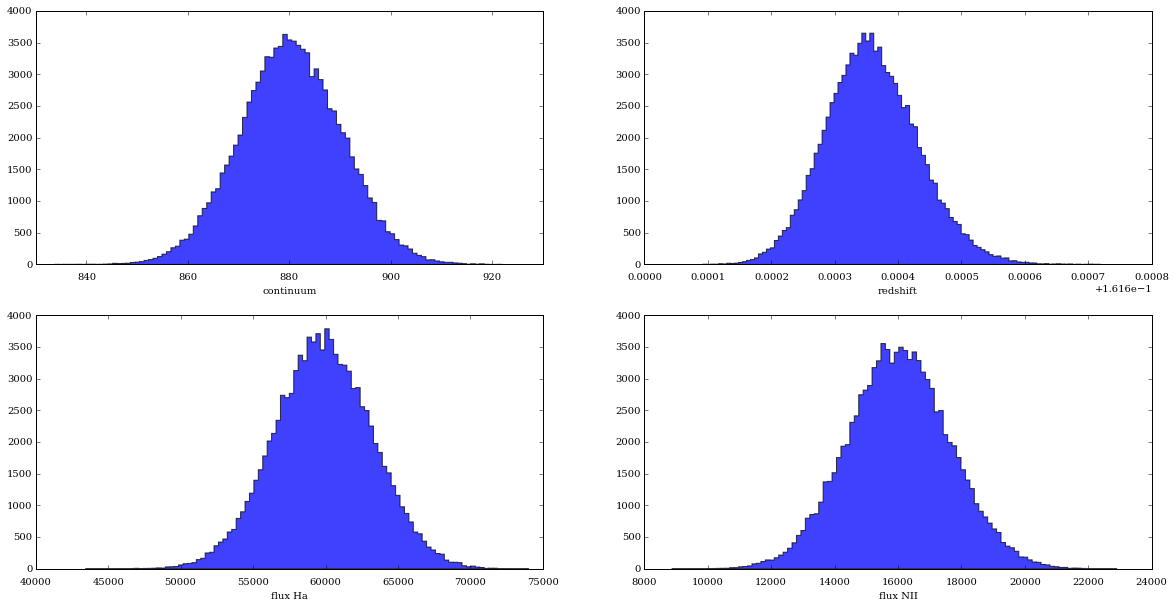

In [31]:
plot_hist(sampler_fixha_pt, par_fixha)

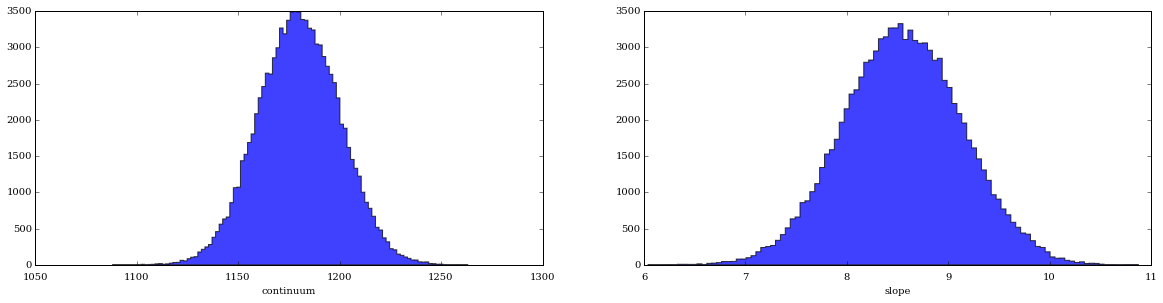

In [32]:
plot_hist(sampler_slope_pt, par_slope)

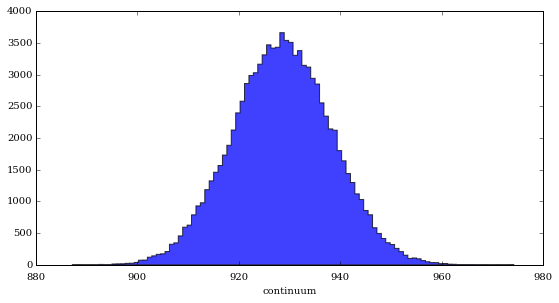

In [33]:
plot_hist(sampler_flat_pt, par_flat)

In [34]:
def plot_func(sampler, model, model_pars=[]):
    xchain = np.arange(xmin, xmax, 1.0)
    ychain = [model(xchain, p, *model_pars) for p in flatten_without_burn(sampler, nburn)]

    plt.figure(figsize=[20,10])
    plt.errorbar(xmeans, ymeans, error_flux, None, 'o')
    for i, y in enumerate(ychain[::100]):
        plt.plot(xchain, y, '-', alpha=0.1, c='green')
    plt.xlim(xmin, xmax)
    plt.show()

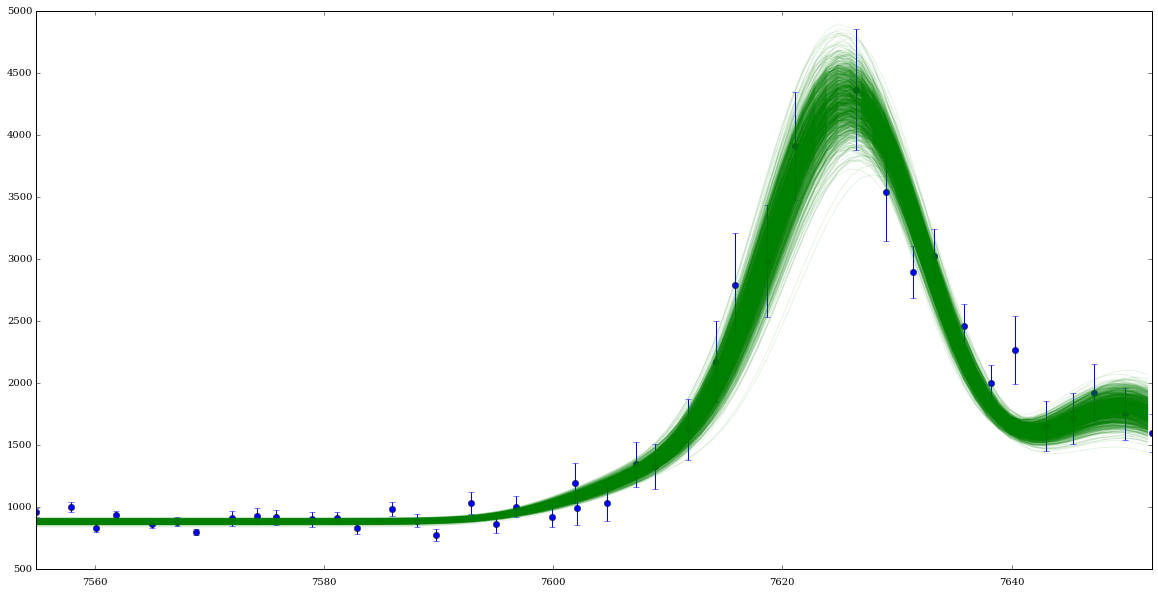

In [35]:
plot_func(sampler_fixha_pt, fixha_model)

In [ ]:
plot_func(sampler_slope_pt, slope_model, [x0])

In [ ]:
plot_func(sampler_flat_pt, flat_model)

In [ ]:
def plot_triangle(sampler, par, model, model_pars=[]):
    xchain = np.arange(xmin, xmax, 1.0)
    ychain = [model(xchain, p, *model_pars) for p in flatten_without_burn(sampler, nburn)]
    triangle.corner(flatten_without_burn(sampler, nburn), labels=par)
    plt.subplot(2, 2, 2)
    for y in ychain[::100]:
        plt.plot(xchain, y, 'r-', alpha=0.01)
    plt.errorbar(xmeans, ymeans, error_flux, None, 'o')
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [ ]:
plot_triangle(sampler_fixha_pt, par_fixha, fixha_model)

In [ ]:
plot_triangle(sampler_slope_pt, par_slope, slope_model, [x0])

In [ ]:
def check_betas(sampler):
    print(sampler.betas)
    logls = sampler.lnlikelihood
    mean_logls = np.mean(np.mean(logls, axis=1)[:, :], axis=1)
    plt.semilogx(sampler.betas, mean_logls, "-o")
    plt.show()

In [ ]:
check_betas(sampler_fixha_pt)

In [ ]:
check_betas(sampler_slope_pt)

In [ ]:
check_betas(sampler_flat_pt)

In [ ]:
def compare_evidence(samplers):
lnZ_fixha, err_lnZ_fixha = sampler_fixha_pt.thermodynamic_integration_log_evidence()
Z_fixha = exp(lnZ_fixha)
err_Z_fixha = Z1t * err_lnZ_fixha
print("Z1t =", Z1t, "+/-", err_Z1t)

In [ ]:
lnZ_slope = sampler_slope_pt.thermodynamic_integration_log_evidence()

In [ ]:
lnZ_flat = sampler_flat_pt.thermodynamic_integration_log_evidence()

In [ ]:
lnZ1t, err_lnZ1t = sampler_2D.thermodynamic_integration_log_evidence()
Z1t = exp(lnZ1t)
err_Z1t = Z1t * err_lnZ1t
print("Z1t =", Z1t, "+/-", err_Z1t)
lnZ2t, err_lnZ2t = sampler_3D.thermodynamic_integration_log_evidence()
Z2t = exp(lnZ2t)
err_Z2t = Z2t * err_lnZ2t
print("Z2t =", Z2t, "+/-", err_Z2t)